In [1]:
import cv2
import math
import time
import numpy as np
from cv2 import norm
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
### Constants ###
# Path to the descriptor files
DESCRIPTOR_FILE_PATH = "side_demo_kpt_des"      
# The maximum distance between two matched keypoints
MAX_MATCH_DISTANCE = 50             
# THe nummber of frames in an interval
INTERVAL = 12
# Create a BFMatcher object with Hamming distance (suitable for ORB, BRIEF, etc.)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)            

In [11]:
def load_kpt_des(interval: int) -> list:
    '''
    description: Load the descriptors from the descriptor file.
    param       {int} interval: The timeline interval of the state.
    return      {list}: A list containing the descriptors for the given interval.
    '''
    file_name = (
        "../" + DESCRIPTOR_FILE_PATH + "/" + 
        DESCRIPTOR_FILE_PATH + str(interval) + ".yml"
    )
    file_storage = cv2.FileStorage(file_name, cv2.FILE_STORAGE_READ)
    # Load the descriptors from the file
    descriptors = file_storage.getNode("descriptors").mat()
    file_storage.release()
    return descriptors

In [20]:
def compare_descriptors(descriptors1: np.ndarray, descriptors2: np.ndarray) -> list:
    '''
    description: Compare two sets of descriptors using BFMatcher.
    param       {np.ndarray} descriptors1: Descriptors from the first set.
    param       {np.ndarray} descriptors2: Descriptors from the second set.
    return      {list}: A list containing pairs of matching keypoints' indices (queryIdx, trainIdx).
    '''
    # Match descriptors from two intervals
    raw_matches = bf.match(descriptors1, descriptors2)
    # Extract pairs of matching keypoints' indices from the matches
    matches = [(match.queryIdx, match.trainIdx) for match in raw_matches]
    return matches

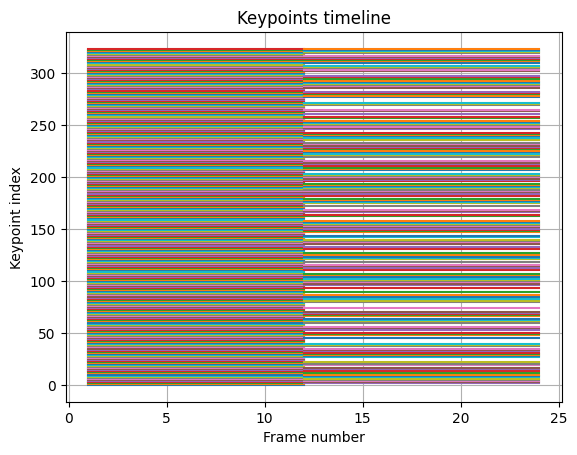

In [24]:
des1 = load_kpt_des(1)
des2 = load_kpt_des(2)
matches = compare_descriptors(des1, des2)
for idx, _ in enumerate(des1):  # Using idx for the index
    plt.plot([1, INTERVAL], [idx, idx])  # Plot the keypoints
for match in matches:
    plt.plot([INTERVAL, INTERVAL*2], [match[0], match[0]])  # Plot the matches
plt.title("Keypoints timeline")
plt.xlabel("Frame number")
plt.ylabel("Keypoint index")
plt.grid(True)
plt.show()